# Import and Define

In [1]:
from plot import *
import numpy as np
import pandas as pd
import polars as pl
from huggingface_hub import hf_hub_download, snapshot_download

from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
palette = {
    'GPN-MSA': "#919191",

    'GPN-Star-V100': "#2773BA",
    'GPN-Star-V100_AF_adjusted': "#2773BA",
    'GPN-Star-M447': "#4F97DB",
    'GPN-Star-P243': "#95BFE6",
    'GPN-Star-P36': "#c1d2e3",
    
    'CADD': '#E09D5A',
    
    'PhyloP-V100': '#9E66BA', 
    'PhastCons-V100': '#C4494B',
    'PhyloP-M447': '#B684D9',
    'PhastCons-M470': '#D96C70',
    'PhyloP-P243': '#D4A6ED',
    'PhastCons-P43': '#EDA8A6',
    
    'NT_2.5B_MS': "#b8b6b6",
    'Evo2_40B': "#b8b6b6",
    'Evo2_7B': "#b8b6b6",
    
    'ESM-1b': '#d6d4d4',

    'Enformer': '#B58181',
    'Borzoi': '#916060',
    'AlphaGenome': '#bd683a',


    'AlphaMissense': '#b5b3b3',
    # 'PrimateAI-3D': '#b5b3b3', not provided due to license restriction

    'Roulette': '#474747',
}

In [3]:
# model groups

gpn_star_models = [
    'GPN-Star-V100',
    'GPN-Star-M447',
    'GPN-Star-P243',
]

gpn_msa = [
    'GPN-MSA',
]

ss_glms = [
    'Evo2_40B',
    'Evo2_7B',
    'NT_2.5B_MS',
]

genome_wide_veps = [
    'CADD',
    'PhyloP-V100',
    'PhastCons-V100',
    'PhyloP-M447',
    'PhastCons-M470',
    'PhyloP-P243',
    'PhastCons-P43',
]

seq2fun_models = [
    'Enformer',
    'Borzoi',
    'AlphaGenome',
]

plm = [
    'ESM-1b',
]

alphamissense = [
    'AlphaMissense',
]

af_adjusted = [
    'GPN-Star-V100_AF_adjusted'
]

mutation_rate = [
    'Roulette'
]

In [4]:
WORK_DIR = 'tmp/'

# ClinVar

In [5]:
snapshot_download(repo_id="songlab/clinvar_vs_benign", local_dir=f"{WORK_DIR}/clinvar", repo_type="dataset")

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

Fetching 22 files: 100%|██████████| 22/22 [00:00<00:00, 1366.45it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/tmp/clinvar'

In [6]:
V_clinvar_vs_b = pd.read_parquet(f'{WORK_DIR}/clinvar/test.parquet')

for m in genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + plm + alphamissense + af_adjusted + mutation_rate:
    V_clinvar_vs_b[m] = pd.read_parquet(f'{WORK_DIR}/clinvar/predictions/{m}.parquet')
V_clinvar_vs_b

,chrom,pos,ref,alt,label,id,review_status,consequence,CADD,PhyloP-V100,...,GPN-Star-M447,GPN-Star-P243,GPN-MSA,Evo2_40B,Evo2_7B,NT_2.5B_MS,ESM-1b,AlphaMissense,GPN-Star-V100_AF_adjusted,Roulette
0,1,930165,G,A,Benign,1164676,"criteria_provided,_single_submitter",missense_variant,-5.525143,-5.113,...,-7.019408,-5.761753,-5.23,-0.002062,-0.001173,0.288513,-8.967,0.6624,-10.000000,1.860495e-07
1,1,930204,G,A,Benign,1170208,"criteria_provided,_single_submitter",missense_variant,-2.912965,-3.430,...,-4.033654,-1.398901,-2.89,-0.001018,0.000095,0.140915,-5.529,0.0866,-10.000000,2.151800e-07
2,1,930285,G,A,Benign,1165489,"criteria_provided,_single_submitter",missense_variant,-0.279046,-0.322,...,-1.690367,-1.846714,-1.54,-0.000106,0.000370,-0.348373,-4.687,0.0629,-10.000000,1.798580e-07
3,1,930314,C,T,Benign,1170010,"criteria_provided,_single_submitter",missense_variant,-2.850487,-3.747,...,-1.868602,-1.343479,-4.98,-0.003383,-0.001416,0.403473,-4.295,0.1098,-10.000000,2.517200e-08
4,1,935779,G,A,Benign,1167937,"criteria_provided,_single_submitter",missense_variant,-1.567354,-2.981,...,-0.725013,-1.508274,4.37,0.001593,0.000528,0.698700,-2.864,0.0607,-10.000000,4.060000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50159,Y,2787412,C,T,Pathogenic,9747,no_assertion_criteria_provided,missense_variant,-3.185060,-5.679,...,1.557563,1.485545,-4.92,-0.000706,-0.000529,-0.912506,-11.344,0.9825,3.670344,NaN
50160,Y,2787426,C,G,Pathogenic,9739,"criteria_provided,_single_submitter",missense_variant,-2.718129,-5.679,...,-2.066342,-2.788243,-6.52,-0.001415,-0.000477,0.021103,-9.000,0.8911,4.340446,NaN
50161,Y,2787515,C,A,Pathogenic,492908,no_assertion_criteria_provided,missense_variant,-1.503127,0.091,...,-2.533743,-0.713252,-0.70,-0.001798,-0.000457,-2.884521,-4.780,0.1177,-1.019781,NaN
50162,Y,2787551,C,T,Pathogenic,9754,no_assertion_criteria_provided,missense_variant,-0.994521,-0.675,...,-1.759026,0.053988,-0.41,-0.000043,-0.000222,0.071259,-4.299,0.1344,-0.150905,NaN


## all models

In [7]:
all_models = genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + plm + mutation_rate
rows = []
V_clinvar_vs_b_c = V_clinvar_vs_b.copy()
V_clinvar_vs_b_c.dropna(subset=all_models, inplace=True)
V_clinvar_vs_b_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_clinvar_vs_b_c.label=="Pathogenic").sum(), (V_clinvar_vs_b_c.label=="Benign").sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc='models'):
    AUROC = roc_auc_score(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
    AUPRC = average_precision_score(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models:   0%|          | 0/16 [00:00<?, ?it/s]

models: 100%|██████████| 16/16 [04:30<00:00, 16.89s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
7,GPN-Star-V100,0.927978,0.907303,0.001168,0.001618
14,ESM-1b,0.915344,0.902267,0.001460,0.001777
0,CADD,0.914091,0.875980,0.001322,0.002260
8,GPN-Star-M447,0.909027,0.870775,0.001354,0.002215
10,GPN-MSA,0.878412,0.856558,0.001745,0.002238
9,GPN-Star-P243,0.861830,0.818206,0.001718,0.002558
1,PhyloP-V100,0.855102,0.800937,0.001745,0.002775
11,Evo2_40B,0.859246,0.789888,0.001699,0.002933
12,Evo2_7B,0.851425,0.780616,0.001745,0.002933
3,PhyloP-M447,0.823015,0.723588,0.001972,0.003223


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


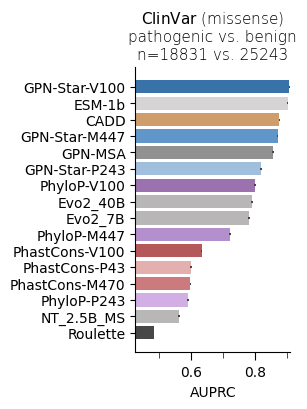

In [8]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,3.7),
    title = r'$\bf{\sf{ClinVar}}$' + f" (missense)\npathogenic vs. benign\nn={n_pos} vs. {n_neg}",
)

## main figure

In [9]:
selected_models = ['GPN-MSA', 'CADD', 'Evo2_40B', 'NT_2.5B_MS', 'GPN-Star-V100', 'PhyloP-V100', 'PhastCons-P43'] + plm
rows = []
V_clinvar_vs_b_c = V_clinvar_vs_b.copy()
V_clinvar_vs_b_c.dropna(subset=[m for m in all_models if m not in mutation_rate], inplace=True) # avoid dropping many variants where Roulette is NA
V_clinvar_vs_b_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_clinvar_vs_b_c.label=="Pathogenic").sum(), (V_clinvar_vs_b_c.label=="Benign").sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(selected_models, desc='models'):
    AUROC = roc_auc_score(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
    AUPRC = average_precision_score(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models:   0%|          | 0/8 [00:00<?, ?it/s]

models: 100%|██████████| 8/8 [02:32<00:00, 19.03s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
4,GPN-Star-V100,0.927113,0.910160,0.001159,0.001505
7,ESM-1b,0.914333,0.905061,0.001436,0.001711
1,CADD,0.912678,0.878416,0.001334,0.002166
0,GPN-MSA,0.881594,0.863798,0.001656,0.002057
5,PhyloP-V100,0.855568,0.808935,0.001756,0.002727
2,Evo2_40B,0.860787,0.801566,0.001595,0.002689
6,PhastCons-P43,0.713888,0.612714,0.002218,0.002628
3,NT_2.5B_MS,0.596646,0.573496,0.002512,0.002619


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


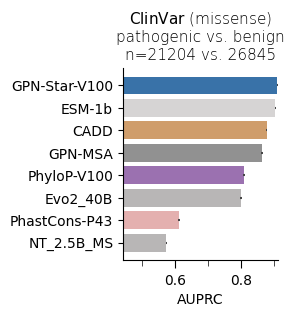

In [10]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,2.5),
    title = r'$\bf{\sf{ClinVar}}$' + f" (missense)\npathogenic vs. benign\nn={n_pos} vs. {n_neg}",
)

## comparison with AlphaMissense

In [11]:
models = ['GPN-Star-V100', 'GPN-Star-M447', 'GPN-Star-P243'] + alphamissense + af_adjusted
rows = []
V_clinvar_vs_b_c = V_clinvar_vs_b.copy()
V_clinvar_vs_b_c.dropna(subset=models, inplace=True) # much fewer variants are dropped since the compared methods are fewer
V_clinvar_vs_b_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_clinvar_vs_b_c.label=="Pathogenic").sum(), (V_clinvar_vs_b_c.label=="Benign").sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(models, desc='models'):
    if m in alphamissense + af_adjusted:
        AUROC = roc_auc_score(V_clinvar_vs_b_c.label=="Pathogenic", V_clinvar_vs_b_c[m])
        AUPRC = average_precision_score(V_clinvar_vs_b_c.label=="Pathogenic", V_clinvar_vs_b_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_clinvar_vs_b_c.label=="Pathogenic", V_clinvar_vs_b_c[m])
    else:
        AUROC = roc_auc_score(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
        AUPRC = average_precision_score(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_clinvar_vs_b_c.label=="Pathogenic", -V_clinvar_vs_b_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models:   0%|          | 0/5 [00:00<?, ?it/s]

models: 100%|██████████| 5/5 [01:34<00:00, 19.00s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
3,AlphaMissense,0.955229,0.949504,0.000907,0.001095
4,GPN-Star-V100_AF_adjusted,0.962672,0.946111,0.000796,0.001294
0,GPN-Star-V100,0.926307,0.909120,0.001174,0.001562
1,GPN-Star-M447,0.906817,0.873598,0.001343,0.002097
2,GPN-Star-P243,0.859845,0.822830,0.001638,0.002418


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


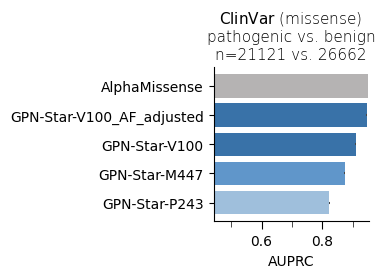

In [12]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,2),
    title = r'$\bf{\sf{ClinVar}}$' + f" (missense)\npathogenic vs. benign\nn={n_pos} vs. {n_neg}",
)

PrimateAI-3D predictions cannot be provided here due to license restriction.

# COSMIC

In [5]:
snapshot_download(repo_id="songlab/cosmic", local_dir=f"{WORK_DIR}/cosmic", repo_type="dataset")

Fetching 20 files: 100%|██████████| 20/20 [00:00<00:00, 1247.43it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/cosmic'

In [6]:
V_cosmic = pd.read_parquet(f'{WORK_DIR}/cosmic/test.parquet')

for m in genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + plm + mutation_rate:
    V_cosmic[m] = pd.read_parquet(f'{WORK_DIR}/cosmic/predictions/{m}.parquet')
V_cosmic

,chrom,pos,ref,alt,label,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-100v,...,PhastCons-M470,PhyloP-P243,PhastCons-P43,GPN-Star-V100,GPN-Star-M447,GPN-Star-P243,Evo2_40B,Evo2_7B,NT_2.5B_MS,Roulette
0,1,69511,A,G,False,1.493164,-0.395063,0.684,-3.290,-0.000,...,-0.000,-0.699,-0.338,2.867621,5.521648,5.108057,0.000339,-0.000079,-1.597534,7.409500e-09
1,1,953279,T,C,False,2.578125,-0.308643,-0.037,-1.270,-0.009,...,-0.000,1.995,-0.064,3.400043,7.222486,6.428992,0.000688,0.000284,-0.583755,5.176500e-09
2,1,973858,G,C,False,1.562500,-0.629825,0.431,-0.835,-0.000,...,-0.000,-0.812,-0.005,2.179322,6.614878,3.232386,0.002399,0.001741,1.605270,7.409500e-09
3,1,973929,T,C,False,-1.328125,-0.727415,-0.076,0.539,-0.001,...,-0.001,0.429,-0.008,-0.647088,-1.129625,0.594300,-0.000495,0.000042,0.537186,8.424500e-09
4,1,976215,A,G,False,-2.527344,-1.461135,-0.054,0.421,-0.000,...,-0.000,-0.221,-0.561,-1.053409,-1.132228,-2.460214,-0.000931,-0.000666,-0.049149,1.187550e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,X,156022062,G,A,False,-6.750000,-2.066306,-6.803,-5.976,-1.000,...,-1.000,NaN,-0.013,-4.699863,-5.498504,-5.607357,-0.000896,-0.000843,-1.478668,NaN
18899,X,156022092,C,T,False,-5.042969,-1.920944,-2.109,-4.822,-0.960,...,-0.389,NaN,-0.993,-3.027400,-3.862323,-3.072916,-0.000518,-0.001219,0.698669,NaN
18900,X,156023118,G,T,False,-5.953125,-2.802924,-4.017,-5.933,-1.000,...,-1.000,NaN,-0.046,-4.192418,-5.831645,-1.396383,0.000489,-0.001497,0.612076,NaN
18901,X,156024251,A,C,False,-3.390625,-3.555679,-6.335,-0.287,-1.000,...,-0.930,NaN,-0.985,-3.045890,0.127649,-0.087693,-0.000590,-0.000612,-0.369339,NaN


## all models

In [15]:
all_models = genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + plm + mutation_rate
rows = []
V_cosmic_c = V_cosmic.copy()
V_cosmic_c.dropna(subset=all_models, inplace=True)
V_cosmic_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_cosmic_c.label==True).sum(), (V_cosmic_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc='models'):
    AUROC = roc_auc_score(V_cosmic_c.label==True, -V_cosmic_c[m])
    AUPRC = average_precision_score(V_cosmic_c.label==True, -V_cosmic_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_cosmic_c.label==True, -V_cosmic_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 16/16 [01:59<00:00,  7.46s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
7,GPN-Star-V100,0.799189,0.493197,0.023046,0.038529
8,GPN-Star-M447,0.787880,0.413412,0.023457,0.040927
10,GPN-MSA,0.794902,0.378774,0.022545,0.039662
9,GPN-Star-P243,0.779001,0.295257,0.023334,0.038024
14,ESM-1b,0.801456,0.227521,0.024222,0.033061
0,CADD,0.769809,0.208375,0.025086,0.031810
1,PhyloP-V100,0.722104,0.148791,0.028196,0.022241
3,PhyloP-M447,0.738089,0.131484,0.026442,0.019728
12,Evo2_7B,0.798014,0.072875,0.019829,0.013236
11,Evo2_40B,0.773456,0.064892,0.020057,0.009200


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


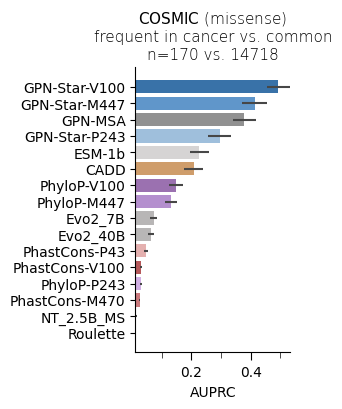

In [16]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,3.7),
    title = r'$\bf{\sf{COSMIC}}$' + f" (missense)\nfrequent in cancer vs. common\nn={n_pos} vs. {n_neg}",
)

## main figure

In [17]:
selected_models = ['GPN-MSA', 'CADD', 'Evo2_40B', 'NT_2.5B_MS', 'GPN-Star-V100', 'PhyloP-V100', 'PhastCons-P43'] + plm
rows = []
V_cosmic_c = V_cosmic.copy()
V_cosmic_c.dropna(subset=[m for m in all_models if m not in mutation_rate], inplace=True) # avoid dropping many variants where Roulette is NA
V_cosmic_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_cosmic_c.label==True).sum(), (V_cosmic_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(selected_models, desc='models'):
    AUROC = roc_auc_score(V_cosmic_c.label==True, -V_cosmic_c[m])
    AUPRC = average_precision_score(V_cosmic_c.label==True, -V_cosmic_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_cosmic_c.label==True, -V_cosmic_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
4,GPN-Star-V100,0.776164,0.466220,0.021664,0.036939
0,GPN-MSA,0.774915,0.356559,0.021010,0.037182
7,ESM-1b,0.789978,0.212554,0.022844,0.030236
1,CADD,0.746063,0.197127,0.023757,0.027852
5,PhyloP-V100,0.690645,0.140243,0.026568,0.020740
2,Evo2_40B,0.760104,0.061209,0.018624,0.008520
6,PhastCons-P43,0.671235,0.044803,0.022418,0.006507
3,NT_2.5B_MS,0.570341,0.016412,0.020792,0.001642


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


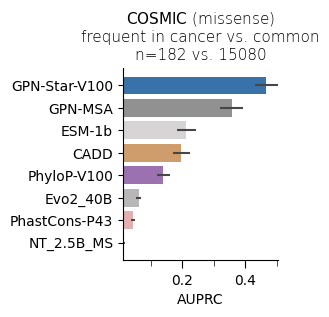

In [18]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,2.5),
    title = r'$\bf{\sf{COSMIC}}$' + f" (missense)\nfrequent in cancer vs. common\nn={n_pos} vs. {n_neg}",
)

# GWAS finemapped missense variants from UKB

In [14]:
snapshot_download(repo_id="songlab/ukb_finemapped_coding", local_dir=f"{WORK_DIR}/fm_coding", repo_type="dataset")

Fetching 21 files: 100%|██████████| 21/21 [00:00<00:00, 535.48it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/fm_coding'

In [15]:
V_fm_coding = pd.read_parquet(f'{WORK_DIR}/fm_coding/test.parquet')

for m in genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + plm + alphamissense + mutation_rate:
    V_fm_coding[m] = pd.read_parquet(f'{WORK_DIR}/fm_coding/predictions/{m}.parquet')
V_fm_coding

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,...,GPN-Star-V100,GPN-Star-M447,GPN-Star-P243,GPN-MSA,Evo2_40B,Evo2_7B,NT_2.5B_MS,ESM-1b,AlphaMissense,Roulette
0,1,946538,G,A,0.000856,,False,0.071222,19.6800,missense_variant,...,-5.058123,-3.154732,-3.393030,7.19,-0.002095,-0.000974,0.238754,-6.302,0.1013,1.222060e-07
1,1,979459,C,T,0.000000,,False,0.051668,23.1540,missense_variant,...,-0.483398,-1.133557,-0.438889,-1.03,-0.000545,-0.000074,1.819153,-3.235,0.0844,2.563890e-07
2,1,1331358,G,A,0.000000,,False,0.074774,23.3600,missense_variant,...,-0.518413,-0.549059,-2.888575,1.47,-0.000623,-0.000549,-3.643997,-5.169,0.1235,1.532650e-08
3,1,2505050,T,G,0.000000,,False,0.007182,81.5180,missense_variant,...,-4.494588,-3.579407,-3.057915,5.57,-0.001040,-0.001448,0.083023,-3.496,0.0688,4.161500e-09
4,1,2526571,G,C,0.000000,,False,0.028311,23.4580,missense_variant,...,-5.494658,-5.349556,-4.762478,5.32,-0.001605,-0.000921,0.939850,-2.472,0.0659,1.065750e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216,9,137255417,C,T,0.000000,,False,0.005064,7.6659,missense_variant,...,-0.303507,-2.159694,-2.513088,1.49,-0.000660,0.000034,-0.682999,-3.016,NaN,1.887900e-08
2217,9,137352691,T,G,0.000000,,False,0.116490,23.9110,missense_variant,...,-2.281192,-2.899356,0.736965,-3.32,0.001071,0.000992,2.434830,-1.243,0.0592,3.045000e-09
2218,9,137356366,C,T,0.000000,,False,0.117690,23.8660,missense_variant,...,0.300661,-3.435326,-1.320726,-1.39,0.000110,-0.000097,1.609009,-3.761,0.0595,4.374650e-08
2219,9,137438026,A,G,0.000000,,False,0.065690,31.2840,missense_variant,...,-2.053733,-3.811286,-3.094001,-3.08,0.001045,0.001415,-1.077179,1.355,0.0399,9.541000e-09


## all models

In [21]:
all_models = genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + plm + mutation_rate
rows = []
V_fm_coding_c = V_fm_coding.copy()
V_fm_coding_c.dropna(subset=all_models, inplace=True)
V_fm_coding_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_fm_coding_c.label==True).sum(), (V_fm_coding_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc='models'):
    if m in gpn_msa + ss_glms:
        AUROC = roc_auc_score(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
        AUPRC = average_precision_score(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
    else:        
        AUROC = roc_auc_score(V_fm_coding_c.label==True, -V_fm_coding_c[m])
        AUPRC = average_precision_score(V_fm_coding_c.label==True, -V_fm_coding_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_coding_c.label==True, -V_fm_coding_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_coding_c.label==True, -V_fm_coding_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 16/16 [01:53<00:00,  7.10s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
8,GPN-Star-M447,0.786797,0.306066,0.015349,0.026665
9,GPN-Star-P243,0.753292,0.271570,0.016796,0.024399
0,CADD,0.730863,0.256605,0.017848,0.024252
7,GPN-Star-V100,0.729445,0.249863,0.018024,0.023618
3,PhyloP-M447,0.731687,0.221970,0.017346,0.018390
10,GPN-MSA,0.702583,0.216624,0.020081,0.012815
14,ESM-1b,0.631135,0.200094,0.020760,0.020987
1,PhyloP-V100,0.690997,0.177411,0.017536,0.013107
4,PhastCons-M470,0.711726,0.176213,0.015168,0.008279
5,PhyloP-P243,0.690872,0.171470,0.017477,0.011290


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


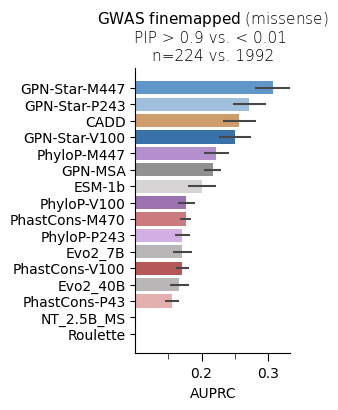

In [22]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,3.7),
    title = r'$\mathbf{\sf{GWAS\ finemapped}}$' + f" (missense)\nPIP > 0.9 vs. < 0.01 \nn={n_pos} vs. {n_neg}",
)

## main figure

In [23]:
selected_models = ['GPN-MSA', 'CADD', 'Evo2_40B', 'NT_2.5B_MS', 'GPN-Star-M447', 'PhyloP-M447', 'PhastCons-M470'] + plm
rows = []
V_fm_coding_c = V_fm_coding.copy()
V_fm_coding_c.dropna(subset=[m for m in all_models if m not in mutation_rate], inplace=True) # avoid dropping many variants where Roulette is NA
V_fm_coding_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_fm_coding_c.label==True).sum(), (V_fm_coding_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(selected_models, desc='models'):
    if m in gpn_msa + ss_glms:
        AUROC = roc_auc_score(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
        AUPRC = average_precision_score(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
    else:        
        AUROC = roc_auc_score(V_fm_coding_c.label==True, -V_fm_coding_c[m])
        AUPRC = average_precision_score(V_fm_coding_c.label==True, -V_fm_coding_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_coding_c.label==True, -V_fm_coding_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 8/8 [00:29<00:00,  3.63s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
4,GPN-Star-M447,0.786971,0.305969,0.015452,0.026653
1,CADD,0.730308,0.256084,0.017904,0.024568
5,PhyloP-M447,0.732307,0.221964,0.017316,0.018513
0,GPN-MSA,0.702569,0.216425,0.018824,0.020151
7,ESM-1b,0.630009,0.198795,0.020594,0.020845
6,PhastCons-M470,0.712314,0.176189,0.015031,0.008222
2,Evo2_40B,0.667132,0.166668,0.018074,0.013249
3,NT_2.5B_MS,0.498269,0.093747,0.018350,0.003982


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


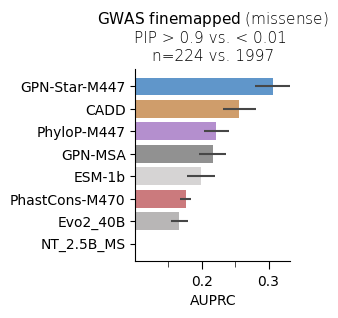

In [24]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,2.5),
    title = r'$\mathbf{\sf{GWAS\ finemapped}}$' + f" (missense)\nPIP > 0.9 vs. < 0.01 \nn={n_pos} vs. {n_neg}",
)

## comparison with AlphaMissense

In [25]:
models = ['GPN-Star-V100', 'GPN-Star-M447', 'GPN-Star-P243'] + alphamissense
rows = []
V_fm_coding_c = V_fm_coding.copy()
V_fm_coding_c.dropna(subset=models, inplace=True) # much fewer variants are dropped since the compared methods are fewer
V_fm_coding_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_fm_coding_c.label==True).sum(), (V_fm_coding_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(models, desc='models'):
    if m in gpn_star_models:
        AUROC = roc_auc_score(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
        AUPRC = average_precision_score(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_coding_c.label==True, np.abs(V_fm_coding_c[m]))
    else:
        AUROC = roc_auc_score(V_fm_coding_c.label==True, V_fm_coding_c[m])
        AUPRC = average_precision_score(V_fm_coding_c.label==True, V_fm_coding_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_coding_c.label==True, V_fm_coding_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
1,GPN-Star-M447,0.781800,0.310267,0.015429,0.026290
2,GPN-Star-P243,0.743571,0.273835,0.017790,0.024809
0,GPN-Star-V100,0.723313,0.250881,0.018011,0.023212
3,AlphaMissense,0.642303,0.205501,0.021660,0.021043


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


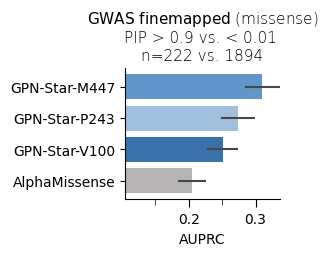

In [26]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,1.7),
    title = r'$\mathbf{\sf{GWAS\ finemapped}}$' + f" (missense)\nPIP > 0.9 vs. < 0.01 \nn={n_pos} vs. {n_neg}",
)

# OMIM

In [27]:
snapshot_download(repo_id="songlab/omim_traitgym", local_dir=f"{WORK_DIR}/omim", repo_type="dataset")

Fetching 24 files: 100%|██████████| 24/24 [00:00<00:00, 1250.82it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/tmp/omim'

In [28]:
V_omim = pd.read_parquet(f'{WORK_DIR}/omim/test.parquet')

for m in genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + seq2fun_models + mutation_rate:
    V_omim[m] = pd.read_parquet(f'{WORK_DIR}/omim/predictions/{m}.parquet')
V_omim

,chrom,pos,ref,alt,OMIM,consequence,label,tss_dist,match_group,CADD,...,GPN-Star-M447,GPN-Star-P243,GPN-MSA,Evo2_40B,Evo2_7B,NT_2.5B_MS,Enformer,Borzoi,AlphaGenome,Roulette
0,1,1425822,C,G,None,PLS,False,48,PLS_4,-0.641057,...,4.749797,3.682890,3.439453,-0.000116,-0.000163,0.333786,-4.809692,-17.851372,-2.335276,3.045000e-09
1,1,1615869,C,T,None,PLS,False,35,PLS_0,-0.168522,...,-1.235664,-0.465043,0.529785,-0.000056,-0.000118,-1.943207,-16.235533,-42.570778,-2.195232,2.781100e-08
2,1,1659060,G,A,None,PLS,False,47,PLS_4,-0.040859,...,0.625767,0.511210,-0.802246,-0.000520,0.000016,-0.022003,-11.277819,-20.612617,-2.582445,1.654450e-08
3,1,1659114,A,G,None,PLS,False,101,PLS_5,-0.962354,...,5.750146,3.393456,4.070312,0.002614,0.001215,3.803986,-70.224617,-182.252731,-16.413376,1.187550e-08
4,1,2050958,T,C,None,5_prime_UTR_variant,False,149,5_prime_UTR_variant_7,-0.382432,...,3.647544,3.099821,1.386719,0.000162,0.000248,1.200867,-6.366479,-20.020468,-1.839422,3.765650e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,X,155613005,C,T,None,PLS,False,52,PLS_52,0.046796,...,-0.780446,-0.893409,1.066406,-0.000463,-0.000057,0.210327,-12.772987,-23.422033,-1.575509,NaN
3376,X,155719093,C,A,None,5_prime_UTR_variant,False,4,5_prime_UTR_variant_101,-0.301978,...,-0.644709,-0.241514,0.505859,-0.000444,-0.000900,-2.122055,-19.870684,-50.873600,-3.582184,NaN
3377,X,155881342,A,C,None,PLS,False,2,PLS_57,-0.325166,...,-1.854492,-2.694321,-3.859375,-0.000496,-0.000004,0.229675,-10.854235,-40.226589,-3.650395,NaN
3378,X,155881414,C,T,None,5_prime_UTR_variant,False,35,5_prime_UTR_variant_110,-0.412759,...,0.197883,0.083082,-1.322266,-0.000560,-0.000177,-1.868210,-12.183937,-27.444807,-2.273986,NaN


## all models

In [29]:
all_models = genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + seq2fun_models + mutation_rate
rows = []
V_omim_c = V_omim.copy()
V_omim_c.dropna(subset=all_models, inplace=True)
V_omim_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_omim_c.label==True).sum(), (V_omim_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc='models'):
    AUROC = roc_auc_score(V_omim_c.label==True, -V_omim_c[m])
    AUPRC = average_precision_score(V_omim_c.label==True, -V_omim_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_omim_c.label==True, -V_omim_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 18/18 [01:06<00:00,  3.72s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
8,GPN-Star-M447,0.919616,0.759993,0.009430,0.023476
7,GPN-Star-V100,0.914204,0.738774,0.009539,0.022805
10,GPN-MSA,0.904940,0.697905,0.009659,0.024295
0,CADD,0.888702,0.694038,0.013198,0.024818
9,GPN-Star-P243,0.908803,0.671966,0.009244,0.026350
3,PhyloP-M447,0.836757,0.660861,0.016561,0.028235
1,PhyloP-V100,0.845194,0.646216,0.015292,0.025905
2,PhastCons-V100,0.835701,0.576161,0.015375,0.028629
11,Evo2_40B,0.857926,0.564697,0.013118,0.026675
6,PhastCons-P43,0.856552,0.507148,0.012794,0.028144


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


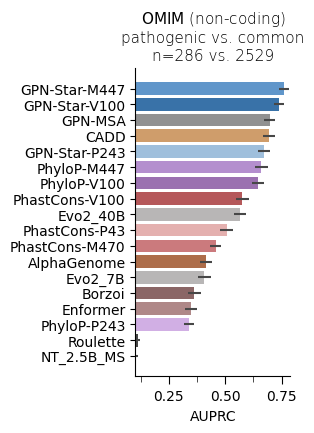

In [30]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,4),
    title = r'$\bf{\sf{OMIM}}$' + f" (non-coding)\npathogenic vs. common\nn={n_pos} vs. {n_neg}",
)

## main figure

In [31]:
selected_models = ['GPN-MSA', 'CADD', 'Evo2_40B', 'NT_2.5B_MS', 'GPN-Star-M447', 'PhyloP-M447', 'PhastCons-V100'] + seq2fun_models
rows = []
V_omim_c = V_omim.copy()
V_omim_c.dropna(subset=[m for m in all_models if m not in mutation_rate], inplace=True) # avoid dropping many variants where Roulette is NA
V_omim_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_omim_c.label==True).sum(), (V_omim_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(selected_models, desc='models'):
    AUROC = roc_auc_score(V_omim_c.label==True, -V_omim_c[m])
    AUPRC = average_precision_score(V_omim_c.label==True, -V_omim_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_omim_c.label==True, -V_omim_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
4,GPN-Star-M447,0.920627,0.765633,0.008506,0.019364
1,CADD,0.892754,0.695152,0.011321,0.021100
0,GPN-MSA,0.904296,0.692302,0.008891,0.021703
5,PhyloP-M447,0.847905,0.674173,0.014499,0.024417
6,PhastCons-V100,0.845916,0.583320,0.013588,0.024826
2,Evo2_40B,0.850028,0.538611,0.012054,0.024589
9,AlphaGenome,0.777280,0.485519,0.014664,0.025420
8,Borzoi,0.767633,0.418449,0.014189,0.025452
7,Enformer,0.761311,0.384151,0.014456,0.026310
3,NT_2.5B_MS,0.534726,0.105635,0.014918,0.005056


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


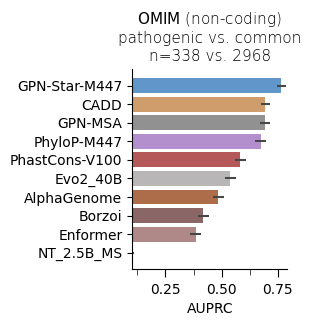

In [32]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,2.6),
    title = r'$\bf{\sf{OMIM}}$' + f" (non-coding)\npathogenic vs. common\nn={n_pos} vs. {n_neg}",
)

# GWAS finemapped non-coding variants from UKB

In [33]:
snapshot_download(repo_id="songlab/ukb_finemapped_nc_traitgym", local_dir=f"{WORK_DIR}/fm_nc", repo_type="dataset")

Fetching 24 files: 100%|██████████| 24/24 [00:00<00:00, 1341.62it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/tmp/fm_nc'

In [34]:
V_fm_nc = pd.read_parquet(f'{WORK_DIR}/fm_nc/test.parquet')

for m in genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + seq2fun_models + mutation_rate:
    V_fm_nc[m] = pd.read_parquet(f'{WORK_DIR}/fm_nc/predictions/{m}.parquet')
V_fm_nc

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,...,GPN-Star-M447,GPN-Star-P243,GPN-MSA,Evo2_40B,Evo2_7B,NT_2.5B_MS,Enformer,Borzoi,AlphaGenome,Roulette
0,1,867476,C,T,0.001560,,False,0.079465,44.053,non_coding_transcript_exon_variant,...,0.100354,-1.996295,-0.435059,-0.000271,0.000010,-0.513214,-4.987669,-10.437775,-1.517673,1.187550e-08
1,1,868052,T,C,0.001791,,False,0.077747,44.057,non_coding_transcript_exon_variant,...,0.576529,-1.757011,1.126953,-0.000575,-0.000014,-0.194336,-6.929053,-20.893782,-1.522286,7.409500e-09
2,1,868635,A,G,0.004349,,False,0.075255,43.639,non_coding_transcript_exon_variant,...,0.184190,-0.924091,0.003906,0.000594,0.000046,0.990051,-9.454313,-8.884507,-1.505500,1.532650e-08
3,1,870176,T,A,0.000000,,False,0.084371,37.271,non_coding_transcript_exon_variant,...,1.982058,1.612884,-1.409180,-0.000312,-0.000465,-3.430084,-10.683093,-15.482671,-1.565185,2.030000e-09
4,1,1052930,A,G,0.001467,,False,0.058385,46.907,non_coding_transcript_exon_variant,...,0.134188,-0.894877,0.703613,0.000344,0.000126,2.313599,-3.548304,-5.096220,-1.765849,3.917900e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,22,50368376,T,C,0.000000,,False,0.191810,86.507,dELS,...,-1.262305,-1.907377,0.433105,0.000492,0.000855,4.034653,-57.451977,-125.532219,-4.535782,3.045000e-09
11396,22,50571623,C,T,0.000000,,False,0.061159,23.900,dELS,...,0.312452,0.541662,-0.004517,-0.000105,-0.000222,-1.476898,-2.317426,-5.384157,-1.527762,9.541000e-09
11397,22,50671289,G,A,0.000000,,False,0.036223,12.733,pELS_flank,...,0.418542,0.528774,1.158203,0.000030,-0.000338,-1.677643,-2.190702,-4.097431,-1.524367,2.141650e-08
11398,22,50713837,C,G,0.000000,,False,0.060562,20.896,dELS,...,0.422603,0.161041,-0.387451,0.000086,-0.000087,-0.100922,-53.621090,-60.973610,-12.482697,8.424500e-09


## all models

In [35]:
all_models = genome_wide_veps + gpn_star_models + gpn_msa + ss_glms + seq2fun_models + mutation_rate
rows = []
V_fm_nc_c = V_fm_nc.copy()
V_fm_nc_c.dropna(subset=all_models, inplace=True)
V_fm_nc_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_fm_nc_c.label==True).sum(), (V_fm_nc_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc='models'):
    if m in gpn_msa + ss_glms:
        AUROC = roc_auc_score(V_fm_nc_c.label==True, np.abs(V_fm_nc_c[m]))
        AUPRC = average_precision_score(V_fm_nc_c.label==True, np.abs(V_fm_nc_c[m]))
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_nc_c.label==True, np.abs(V_fm_nc_c[m]))
    else:        
        AUROC = roc_auc_score(V_fm_nc_c.label==True, -V_fm_nc_c[m])
        AUPRC = average_precision_score(V_fm_nc_c.label==True, -V_fm_nc_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_nc_c.label==True, -V_fm_nc_c[m])
    AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_nc_c.label==True, -V_fm_nc_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 18/18 [03:49<00:00, 12.74s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
8,GPN-Star-M447,0.645635,0.259900,0.009775,0.012708
0,CADD,0.616746,0.239969,0.009740,0.012568
16,AlphaGenome,0.665547,0.239731,0.009080,0.011701
9,GPN-Star-P243,0.634109,0.238020,0.010333,0.012131
6,PhastCons-P43,0.619202,0.227528,0.009944,0.011485
14,Enformer,0.651148,0.227310,0.009119,0.011262
7,GPN-Star-V100,0.616679,0.227150,0.010120,0.011905
15,Borzoi,0.649895,0.218374,0.009361,0.011062
3,PhyloP-M447,0.602390,0.216519,0.009898,0.011974
10,GPN-MSA,0.607767,0.209718,0.010152,0.010802


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


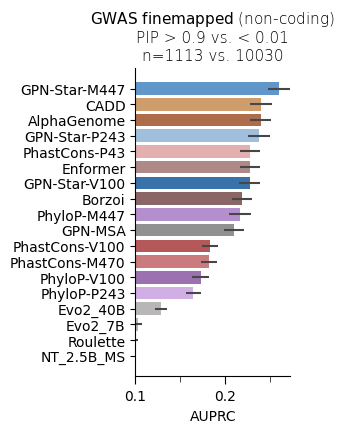

In [36]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,4),
    title = r'$\bf{\sf{GWAS\ finemapped}}$' + f" (non-coding)\nPIP > 0.9 vs. < 0.01\nn={n_pos} vs. {n_neg}",
)

## main figure

In [37]:
selected_models = ['GPN-MSA', 'CADD', 'Evo2_40B', 'NT_2.5B_MS', 'GPN-Star-M447', 'PhyloP-M447', 'PhastCons-P43'] + seq2fun_models
rows = []
V_fm_nc_c = V_fm_nc.copy()
V_fm_nc_c.dropna(subset=[m for m in all_models if m not in mutation_rate], inplace=True) # avoid dropping many variants where Roulette is NA
V_fm_nc_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_fm_nc_c.label==True).sum(), (V_fm_nc_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(selected_models, desc='models'):
    if m in gpn_msa + ss_glms:
        AUROC = roc_auc_score(V_fm_nc_c.label==True, np.abs(V_fm_nc_c[m]))
        AUPRC = average_precision_score(V_fm_nc_c.label==True, np.abs(V_fm_nc_c[m]))
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_nc_c.label==True, np.abs(V_fm_nc_c[m]))
    else:        
        AUROC = roc_auc_score(V_fm_nc_c.label==True, -V_fm_nc_c[m])
        AUPRC = average_precision_score(V_fm_nc_c.label==True, -V_fm_nc_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_fm_nc_c.label==True, -V_fm_nc_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 10/10 [01:06<00:00,  6.62s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
4,GPN-Star-M447,0.645634,0.259860,0.009822,0.012540
9,AlphaGenome,0.665579,0.239702,0.009036,0.011657
1,CADD,0.616674,0.238755,0.009800,0.012336
6,PhastCons-P43,0.619163,0.227467,0.010087,0.011446
7,Enformer,0.651235,0.227280,0.009120,0.010986
8,Borzoi,0.649988,0.218350,0.009231,0.010711
5,PhyloP-M447,0.602433,0.216483,0.009900,0.011772
0,GPN-MSA,0.607689,0.209630,0.009880,0.011158
2,Evo2_40B,0.509673,0.128011,0.009201,0.006771
3,NT_2.5B_MS,0.466921,0.091301,0.009246,0.002420


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


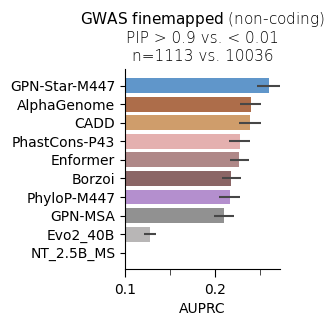

In [38]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,2.6),
    title = r'$\bf{\sf{GWAS\ finemapped}}$' + f" (non-coding)\nPIP > 0.9 vs. < 0.01\nn={n_pos} vs. {n_neg}",
)

HGMD data cannot provided due to copyright restriction.

# gnomAD rare vs. common enrichment

In [39]:
snapshot_download(repo_id="songlab/gnomad_balanced", local_dir=f"{WORK_DIR}/gnomad", repo_type="dataset")

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 1536.04it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/tmp/gnomad'

In [40]:
V_gnomad = pd.read_parquet(f'{WORK_DIR}/gnomad/test.parquet')

selected_models = genome_wide_veps + gpn_msa + gpn_star_models + mutation_rate
for m in selected_models:
    V_gnomad[m] = pd.read_parquet(f'{WORK_DIR}/gnomad/predictions/{m}.parquet')

In [41]:
V_gnomad = pl.from_pandas(V_gnomad) # compute in polars for efficiency
V_gnomad

chrom,pos,ref,alt,label,consequence,CADD,PhyloP-V100,PhastCons-V100,PhyloP-M447,PhastCons-M470,PhyloP-P243,PhastCons-P43,GPN-MSA,GPN-Star-V100,GPN-Star-M447,GPN-Star-P243,Roulette
str,i64,str,str,bool,str,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f64
"""1""",13273,"""G""","""C""",false,"""non_coding_transcript_exon""",0.398596,1.091,1.0,0.37,0.293,0.068,0.915,4.07251,-2.388706,-2.287445,-2.820153,-5.1765e-9
"""1""",14464,"""A""","""T""",false,"""non_coding_transcript_exon""",-0.339809,-1.705,0.0,-1.69,0.0,0.048,0.004,-0.89502,2.332724,0.675804,0.485637,-3.0450e-9
"""1""",15211,"""T""","""G""",false,"""intron""",0.228371,-0.944,0.0,-0.395,0.0,0.0,0.002,0.74707,0.827433,0.769691,0.854642,-2.0300e-9
"""1""",16257,"""G""","""C""",false,"""intron""",-0.475726,-1.186,0.0,-1.039,0.0,0.0,0.002,0.17627,0.957751,-0.038206,0.500973,-6.2930e-9
"""1""",16487,"""T""","""C""",false,"""intron""",1.55539,0.506,0.692,-3.485,0.0,-2.401,0.39,3.698242,-1.122141,0.381461,-1.350773,-9.5410e-9
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Y""",23383063,"""C""","""G""",true,"""intron""",0.088275,null,null,0.0,0.001,null,null,0.379883,0.884146,1.003537,1.843695,null
"""Y""",24777146,"""T""","""C""",true,"""intron""",0.246137,0.055,0.187,0.064,0.001,0.048,null,0.2734375,1.119876,2.464217,1.751523,null
"""Y""",56828145,"""A""","""T""",true,"""intergenic""",0.175074,null,null,0.0,0.0,null,null,-0.148438,2.21145,3.108315,2.952123,null


In [42]:
results_gnomad = []
for c in tqdm(V_gnomad['consequence'].unique().to_list()+['all']):
    if c != 'all' and (V_gnomad['consequence']==c).sum() < 500:
        continue
    df_c = V_gnomad.clone() if c == "all" else V_gnomad.filter(pl.col("consequence") == c)
    df_c = df_c.drop_nulls(subset=selected_models)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in selected_models:
        try:
            if m not in gpn_star_models:
                # Fix: Apply negation to the score column instead of the DataFrame
                selected_df = df_c.select(["label", pl.col(m).alias("score")])
                selected_df = selected_df.with_columns(pl.col("score") * -1)
                odds_ratio = (
                    get_odds_ratio(selected_df, [30])
                    .with_columns(
                        Consequence=pl.lit(c), Model=pl.lit(m),
                        n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
                    )
                )
                results_gnomad.append(odds_ratio)
            else:
                odds_ratio = (
                    get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30])
                    .with_columns(
                        Consequence=pl.lit(c), Model=pl.lit(m),
                        n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
                    )
                )
                results_gnomad.append(odds_ratio)
        except:
            pass

results_gnomad = pl.concat(results_gnomad).to_pandas()
results_gnomad.head()

100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,4.033198,7.612353e-15,intergenic,CADD,2107699,2125098
1,30,7.188531,3.592368e-37,intergenic,PhyloP-V100,2107699,2125098
2,30,1.856318,0.000000e+00,intergenic,PhastCons-V100,2107699,2125098
3,30,4.292518,1.868762e-18,intergenic,PhyloP-M447,2107699,2125098
4,30,1.798877,0.000000e+00,intergenic,PhastCons-M470,2107699,2125098


In [43]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "splice_region": "splice-region",
    "start_or_stop": "start-or-stop",
}
results_gnomad['Consequence'] = results_gnomad['Consequence'].replace(replacements)

In [44]:
results_gnomad = results_gnomad.sort_values('Odds ratio', ascending = False)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(


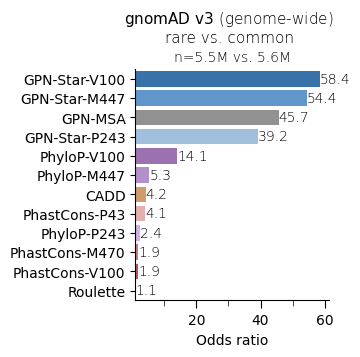

In [45]:
barplot_with_numbers(
    results_gnomad[
        (results_gnomad.p_value < 0.05) &
        (results_gnomad.Consequence == "all")
    ],
    "Odds ratio",
    r"$\bf{\sf{gnomAD\ v3}}$" + " (genome-wide)\nrare vs. common",
    palette=palette,
    y=1.08,
    width=2.5, height=3,
)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:295: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:295: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:295: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/notebooks/plot.py:295: FutureWarning: 

Passing `palette` without assigning `hue` is deprecat

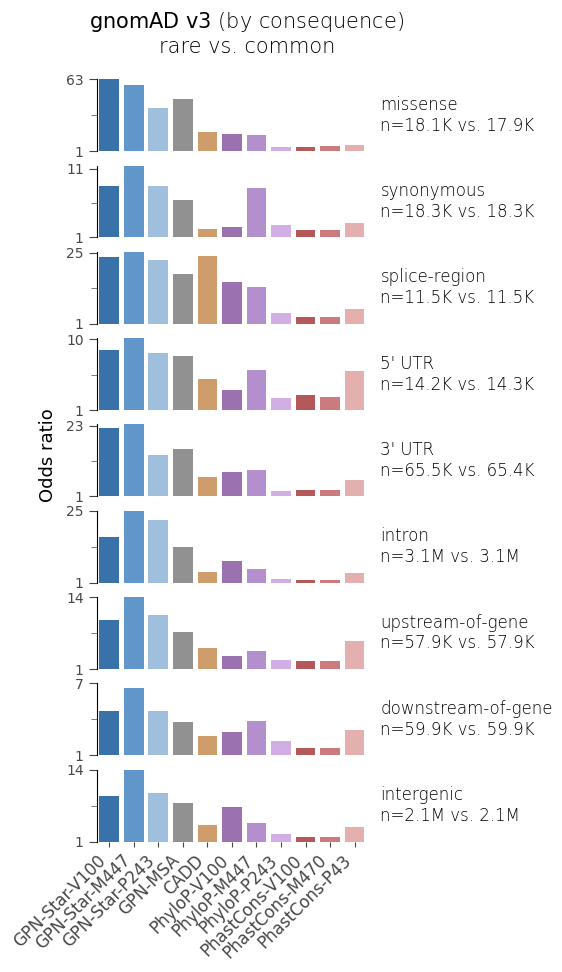

In [46]:
barplot_vertical_aligned(
    results_gnomad[(results_gnomad.n==30) & (results_gnomad.p_value < 0.05)],
    metric="Odds ratio",
    title=r'$\bf{\sf{gnomAD\ v3}}$' + " (by consequence)\nrare vs. common",
    palette=palette,
    width=4,
    height=1.1,
    hspace=0.2,
    suptitle_y=0.95,
    model_order=['GPN-Star-V100', 'GPN-Star-M447', 'GPN-Star-P243', 
                 'GPN-MSA', 'CADD',
                 'PhyloP-V100', 'PhyloP-M447', 'PhyloP-P243', 
                 'PhastCons-V100', 'PhastCons-M470', 'PhastCons-P43',
                 ],
    group_order=['missense', 'synonymous', 'splice-region', "5' UTR", "3' UTR", 'intron', 'upstream-of-gene', 'downstream-of-gene', 'intergenic'],
)
